# API : Quick Start

In [5]:
import pymc3 as pm
import numpy as np

In [2]:
with pm.Model() as model_a:
    pass

In [8]:
with pm.Model() as model_rv:
    mu = pm.Normal('mu', mu=0, sd=1)
    obs = pm.Normal('obs', mu=mu, sd=1, 
                    observed=np.random.randn(100))

In [15]:
model_rv.basic_RVs, model_rv.free_RVs, model_rv.observed_RVs

([mu, obs], [mu], [obs])

In [17]:
model_rv.logp({'mu' : 0})

array(-144.1782207)

## Bounded to Unbounded RVs

In [18]:
with pm.Model() as model:
    x = pm.Uniform('x', lower=2, upper=6)

In [23]:
model.free_RVs, type(model.free_RVs[0])

([x_interval__], pymc3.model.FreeRV)

`x_interval__` represents `x` transformed to accept parameter values between -inf and +inf. 

## Higher Dimensional RV

In [26]:
with pm.Model() as model:
    x = pm.Normal('x', mu=0, sd=1, shape=10)

In [29]:
with model:
    y = x[0] * x[1]

In [33]:
x.tag.test_value

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Inference

> The main entry point to MCMC sampling algorithms is via the `pm.sample()`.

In [38]:
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sd=1)
    obs = pm.Normal('obs', mu=mu, sd=1,
                    observed=np.random.randn(100))
    trace = pm.sample(1000, tune=500, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:02<00:00, 2167.15draws/s]


In [41]:
len(trace)

1000

In [42]:
trace['mu'].shape

(4000,)

In [45]:
trace.get_values('mu', chains=1).shape

(1000,)

## Selecting Sampler

```
step = pm.Metropolis()
trace = pm.sample(1000, step=step)
```

## Assign Variables to different step methods

```
step1 = pm.Metropolis(vars=[mu])
step2 = pm.Slice(vars=[sd])
trace = pm.sample(10000, step=[step1, step2], cores=4)
```

## Trace Plot

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11647e908>,
      dtype=object)

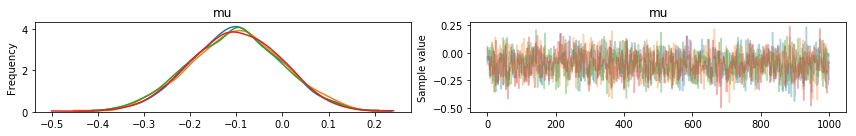

In [46]:
pm.traceplot(trace)

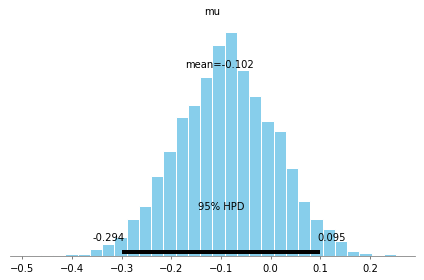

In [49]:
pm.plot_posterior(trace)

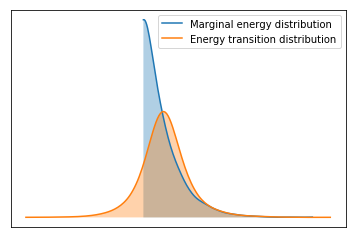

In [51]:
pm.energyplot(trace)

## Variational Inference

In [52]:
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sd=1)
    sd = pm.HalfNormal('sd', sd=1)
    obs = pm.Normal('obs', mu=mu, sd=sd,
                    observed=np.random.randn(100))
    approx = pm.fit()

Average Loss = 148.07: 100%|██████████| 10000/10000 [00:06<00:00, 1531.78it/s]
Finished [100%]: Average Loss = 148.06


### Sample from approximate posterior

In [53]:
approx.sample(500)

## Full-Rank ADVI

In [54]:
mu = pm.floatX([0., 0.])
cov = pm.floatX([[1., .5], [0.5, 1.]])
with pm.Model() as model:
    pm.MvNormal('x', mu=mu, cov=cov, shape=2)
    approx = pm.fit(method='fullrank_advi')

  0%|          | 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.6/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/usr/local/lib/python3.6/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/usr/local/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the fu

In [59]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
sns.set_context('notebook')

/usr/local/lib/python3.6/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


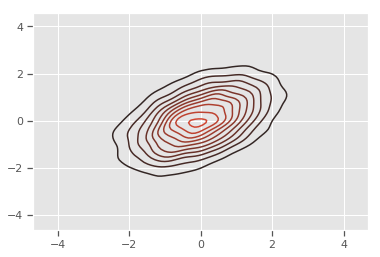

In [60]:
plt.figure()
trace = approx.sample(10000)
sns.kdeplot(trace['x'][:, 0], trace['x'][:, 1])

## Posterior Predictive Sampling

- Prediction on Hold-out data

In [69]:
data = np.random.randn(100)
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sd=1)
    sd = pm.HalfNormal('sd', sd=1)
    obs = pm.Normal('obs', mu=mu, sd=sd, observed=data)
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, mu]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:01<00:00, 1064.58draws/s]
The acceptance probability does not match the target. It is 0.8842584462807289, but should be close to 0.8. Try to increase the number of tuning steps.


In [70]:
with model:
    post_pred = pm.sample_posterior_predictive(trace, samples=500, size=len(data))

100%|██████████| 500/500 [00:00<00:00, 636.63it/s]


In [71]:
post_pred['obs'].shape

(500, 100, 100)